# Exercise 4: Financial Statement Analysis #2
In this exercise, we will conduct a financial statement analysis of the state commercial banking industry, classified under SIC code 6022. Our focus will be on identifying potential liquidity risks similar to those that contributed to the collapse of Silicon Valley Bank in 2022, particularly those stemming from Unrealized Losses on Available-for-Sale (AFS) securities.

Banks differ in how they report Unrealized Gains and Losses (G/L) on AFS securities—some report these amounts before taxes, while others report them net of taxes. We will address this inconsistency in the dataset to ensure comparability across institutions. Once standardized, we will analyze each bank’s Unrealized G/L (both before and after tax) as a percentage of their total assets to assess potential security-related liquidity risks.



# Step 1: Import Required Stata Modules

In [1]:
import os, re, sys, json, requests, getpass, urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime
from urllib.parse import urlencode

# Step 2: Obtain XBRL API Access

In [2]:
password = getpass.getpass(prompt = 'xX15892002$:')

body_auth = {'username' : 'amm9890@psu.edu', 
            'client_id': 'cdbc60fc-a4b1-44f6-91bc-e7c8a9adf54a', 
            'client_secret' : 'a15b1993-7448-41db-ae43-ebeecb2cf26f', 
            'password' : ''.join(password), 
            'grant_type' : 'password', 
            'platform' : 'ipynb' }

payload = urlencode(body_auth)
url = 'https://api.xbrl.us/oauth2/token'
headers = {"Content-Type": "application/x-www-form-urlencoded"}

res = requests.request("POST", url, data = payload, headers = headers)
auth_json = res.json()

if 'error' in auth_json:
    print ("Access Denied")
else:
    print ("Access Granted.")
    
access_token = auth_json['access_token']
refresh_token = auth_json['refresh_token']
newaccess = ''
newrefresh = ''

Access Granted.


# Step 3: 
Define the XBRL elements we want to extract from the financial filings. These elements represent specific financial metrics or data points, such as unrealized gains/losses, income before tax, and total assets, which will be used for further analysis.

In [3]:
XBRL_Elements = ['OtherComprehensiveIncomeUnrealizedHoldingGainLossOnSecuritiesArisingDuringPeriodBeforeTax, OtherComprehensiveIncomeUnrealizedHoldingGainLossOnSecuritiesArisingDuringPeriodNetOfTax,IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,IncomeTaxExpenseBenefit,Assets']

##### Substep Step 3.2: 
For this step, we will be looking at 10-K filings in 2022. The analysis will focus on the SIC code "6022," which includes all State Commercial Banks

In [4]:
Filings = ['10-K']
Years = ['2022']
SIC = ['6022']



##### Substep 3.3: Run the Query
The query will store the data in a DataFrame titled *df*. This step will look different from past exercises in the guide. Prior to converting API data pull into a DataFrame, the code will organize the concept tags (e.g., Assets) into their own column with their respective values. This will reduce the steps in cleaning the data and potential errors. 

In [5]:
Fields = ['entity.cik',
          'entity.name.sort(ASC)',
          'report.filing-date',
          'period.fiscal-year',
          'report.document-type',
          'concept.local-name',
          'fact.value',
          'unit',
          'report.sic-code']

Parameters = {'concept.local-name': ','.join(XBRL_Elements),
              'period.fiscal-year': ','.join(Years),
              'unit': 'USD',
              'report.document-type': ','.join(Filings),
              'report.sic-code': ','.join(SIC),}  

has_dimensions = 'FALSE'

if has_dimensions == 'ALL':
    dimension_options = ['TRUE', 'FALSE']
else:
    dimension_options = [has_dimensions]

search_endpoint = 'https://api.xbrl.us/api/v1/fact/search'
    
all_res_list = []
for dimensions_param in dimension_options:

    print('Getting the data for: "fact.has-dimensions" = {}'.format(dimensions_param))
    
    done_retrieving_all_results = False
    offset = 0

    while not done_retrieving_all_results:

        Parameters['fact.has-dimensions'] = dimensions_param
        Parameters['fields'] = ','.join(Fields) + ',fact.offset({})'.format(offset) 

        res = requests.get(search_endpoint, params = Parameters, headers={'Authorization' : 'Bearer {}'.format(access_token)})
        
        res_json = res.json()
        res_list = res_json['data']
        all_res_list += res_list
        
        paging_dict = res_json['paging']

        print('Number of Observations Obtained: ', paging_dict['count'])

        if paging_dict['count'] >= 2000:
            offset += paging_dict['count']
        else:
            done_retrieving_all_results = True



restructured_data = []
for item in all_res_list:
    existing_entry = next(
        (entry for entry in restructured_data if entry['entity.cik'] == item['entity.cik'] and entry['report.filing-date'] == item['report.filing-date']),
        None
    )
   
    if existing_entry:
        existing_entry[item['concept.local-name']] = item['fact.value']
    else:
        new_entry = {
            'entity.cik': item['entity.cik'],
            'entity.name': item['entity.name'],
            'report.filing-date': item['report.filing-date'],
            'period.fiscal-year': item['period.fiscal-year'],
            'report.document-type': item['report.document-type'],
            'unit': item['unit'],
            'report.sic-code': item['report.sic-code']
        }
        new_entry[item['concept.local-name']] = item['fact.value']
        restructured_data.append(new_entry)
    
df = pd.DataFrame(restructured_data)
print('Number of Observations: {}'.format(len(df)))


Getting the data for: "fact.has-dimensions" = FALSE
Number of Observations Obtained:  3682
Number of Observations Obtained:  0
Number of Observations: 527


##### Substep 3.4:
In this step we will convert our DataFrame to banks. Whenever you are working with DataFrames and manipulating the code, make sure you are aware of the changes that are happening from step to step. Looking at the DataFrame will ensure the DataFrame is being properly manipulated

In [6]:
banks = df
banks

,entity.cik,entity.name,report.filing-date,period.fiscal-year,report.document-type,unit,report.sic-code,OtherComprehensiveIncomeUnrealizedHoldingGainLossOnSecuritiesArisingDuringPeriodBeforeTax,IncomeTaxExpenseBenefit,Assets,IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,OtherComprehensiveIncomeUnrealizedHoldingGainLossOnSecuritiesArisingDuringPeriodNetOfTax
0,0000034782,1st Source Corporation,2024-02-20,2022,10-K,USD,6022,-181237000.0,36255000.0,8.339416e+09,NaN,NaN
1,0000034782,1st Source Corporation,2023-02-16,2022,10-K,USD,6022,-181237000.0,36255000.0,8.339416e+09,NaN,NaN
2,0000034782,1st Source Corporation,2025-02-18,2022,10-K,USD,6022,-181237000.0,36255000.0,NaN,NaN,NaN
3,0000715579,ACNB CORPORATION,2024-03-14,2022,10-K,USD,6022,NaN,NaN,2.525507e+09,4.495100e+07,-46441000.0
4,0000715579,ACNB CORPORATION,2025-03-14,2022,10-K,USD,6022,NaN,NaN,2.525507e+09,4.495100e+07,-46441000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
522,0001212545,WESTERN ALLIANCE BANCORPORATION,2025-02-25,2022,10-K,USD,6022,NaN,258800000.0,NaN,1.316100e+09,-674900000.0
523,0001212545,WESTERN ALLIANCE BANCORPORATION,2023-02-23,2022,10-K,USD,6022,NaN,258800000.0,6.773400e+10,1.316100e+09,-674900000.0
524,0001015328,Wintrust Financial Corp,2025-02-28,2022,10-K,USD,6022,-537602000.0,190873000.0,5.294965e+10,7.005550e+08,-394332000.0
525,0001015328,Wintrust Financial Corp,2023-02-28,2022,10-K,USD,6022,-537602000.0,190873000.0,5.294965e+10,7.005550e+08,-394332000.0


# Step 4: Clean the Data


#### Substep 4.1: Rename Columns
In this step we will be changing the column names to be more presentable. There are different ways to do this using Python

In [7]:
banks.rename(columns = {
    'entity.cik': 'CIK',
    'entity.name': 'Company',
    'report.filing-date': 'Filing Date',
    'period.fiscal-year': 'Year',
    'report.document-type': 'Filing',
    'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest': 'Income Before Tax',
    'OtherComprehensiveIncomeUnrealizedHoldingGainLossOnSecuritiesArisingDuringPeriodBeforeTax': 'Unrealized Gain/Loss Before Tax',
    'OtherComprehensiveIncomeUnrealizedHoldingGainLossOnSecuritiesArisingDuringPeriodNetOfTax': 'Unrealized Gain/Loss After Tax',
    'Assets': 'Total Assets',
    'fact.value': 'Value',
    'unit': 'Unit',
    'report.sic-code': 'SIC code'
}, inplace=True)

banks

,CIK,Company,Filing Date,Year,Filing,Unit,SIC code,Unrealized Gain/Loss Before Tax,IncomeTaxExpenseBenefit,Total Assets,Income Before Tax,Unrealized Gain/Loss After Tax
0,0000034782,1st Source Corporation,2024-02-20,2022,10-K,USD,6022,-181237000.0,36255000.0,8.339416e+09,NaN,NaN
1,0000034782,1st Source Corporation,2023-02-16,2022,10-K,USD,6022,-181237000.0,36255000.0,8.339416e+09,NaN,NaN
2,0000034782,1st Source Corporation,2025-02-18,2022,10-K,USD,6022,-181237000.0,36255000.0,NaN,NaN,NaN
3,0000715579,ACNB CORPORATION,2024-03-14,2022,10-K,USD,6022,NaN,NaN,2.525507e+09,4.495100e+07,-46441000.0
4,0000715579,ACNB CORPORATION,2025-03-14,2022,10-K,USD,6022,NaN,NaN,2.525507e+09,4.495100e+07,-46441000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
522,0001212545,WESTERN ALLIANCE BANCORPORATION,2025-02-25,2022,10-K,USD,6022,NaN,258800000.0,NaN,1.316100e+09,-674900000.0
523,0001212545,WESTERN ALLIANCE BANCORPORATION,2023-02-23,2022,10-K,USD,6022,NaN,258800000.0,6.773400e+10,1.316100e+09,-674900000.0
524,0001015328,Wintrust Financial Corp,2025-02-28,2022,10-K,USD,6022,-537602000.0,190873000.0,5.294965e+10,7.005550e+08,-394332000.0
525,0001015328,Wintrust Financial Corp,2023-02-28,2022,10-K,USD,6022,-537602000.0,190873000.0,5.294965e+10,7.005550e+08,-394332000.0


#### Substep 4.2: Remove Duplicate Observations
In this step, we are performing two operations on the `banks` DataFrame:

1. **Sorting the DataFrame**: We first sort the rows of the `banks` DataFrame by the columns `CIK` and `Filing` in ascending order. This ensures that the data is organized in a consistent order, which is helpful for identifying duplicates.

2. **Removing Duplicates**: After sorting, we remove duplicate rows based on the combination of the `CIK` and `Filing` columns. If multiple rows have the same values for these columns, only the first occurrence is kept, and the rest are dropped. This helps to ensure that each unique combination of `CIK` and `Filing` appears only once in the resulting DataFrame, `banks2`.
```

In [8]:
banks2 = banks.sort_values(by=['CIK', 'Filing'])
banks2 = banks.drop_duplicates(subset=['CIK', 'Filing'], keep='first')
banks2

,CIK,Company,Filing Date,Year,Filing,Unit,SIC code,Unrealized Gain/Loss Before Tax,IncomeTaxExpenseBenefit,Total Assets,Income Before Tax,Unrealized Gain/Loss After Tax
0,0000034782,1st Source Corporation,2024-02-20,2022,10-K,USD,6022,-181237000.0,36255000.0,8.339416e+09,NaN,NaN
3,0000715579,ACNB CORPORATION,2024-03-14,2022,10-K,USD,6022,NaN,NaN,2.525507e+09,4.495100e+07,-4.644100e+07
6,0000040729,ALLY FINANCIAL INC.,2024-02-20,2022,10-K,USD,6022,NaN,627000000.0,1.918260e+11,2.342000e+09,-3.982000e+09
9,0001823608,Amalgamated Financial Corp.,2024-03-07,2022,10-K,USD,6022,NaN,26687000.0,7.843124e+09,NaN,NaN
12,0000351569,AMERIS BANCORP,2025-02-28,2022,10-K,USD,6022,NaN,106558000.0,2.505329e+10,4.530980e+08,-6.209700e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
513,0001290476,Village Bank & Trust Financial Corp.,2023-03-20,2022,10-K,USD,6022,-12843000.0,1990000.0,7.232700e+08,1.029500e+07,-1.014600e+07
515,0000737468,"WASHINGTON TRUST BANCORP, INC",2024-02-26,2022,10-K,USD,6022,-163471000.0,19489000.0,6.660051e+09,9.117000e+07,-1.242380e+08
518,0001166928,"WEST BANCORPORATION, INC.",2023-02-23,2022,10-K,USD,6022,-132009000.0,12998000.0,3.613218e+09,5.939700e+07,NaN
521,0001212545,WESTERN ALLIANCE BANCORPORATION,2024-02-28,2022,10-K,USD,6022,NaN,258800000.0,6.773400e+10,1.316100e+09,-6.749000e+08


#### Substep 4.3: Remove NaN Variables
In this step, we are cleaning the `banks2` DataFrame by removing rows that contain missing (`NaN`) values in the columns `'IncomeTaxExpenseBenefit'` and `'Income Before Tax'`. These columns are essential for subsequent calculations, such as determining the tax rate. By dropping rows with missing values in these columns, we ensure that the data is complete and compatible for performing accurate calculations in later steps.


In [ ]:
banks2 = banks2.dropna(subset=['IncomeTaxExpenseBenefit', 'Income Before Tax'])
banks2

,CIK,Company,Filing Date,Year,Filing,Unit,SIC code,Unrealized Gain/Loss Before Tax,IncomeTaxExpenseBenefit,Total Assets,Income Before Tax,Unrealized Gain/Loss After Tax
6,0000040729,ALLY FINANCIAL INC.,2024-02-20,2022,10-K,USD,6022,NaN,627000000.0,1.918260e+11,2.342000e+09,-3.982000e+09
12,0000351569,AMERIS BANCORP,2025-02-28,2022,10-K,USD,6022,NaN,106558000.0,2.505329e+10,4.530980e+08,-6.209700e+07
18,0000883948,ATLANTIC UNION BANKSHARES CORPORATION,2025-02-27,2022,10-K,USD,6022,NaN,45444000.0,NaN,2.800000e+08,-3.866840e+08
21,0000750574,"Auburn National Bancorporation, Inc.",2023-03-17,2022,10-K,USD,6022,NaN,2503000.0,1.023888e+09,1.284900e+07,-4.180200e+07
23,0001118004,BANCPLUS CORPORATION,2023-03-09,2022,10-K,USD,6022,-57312000.0,16614000.0,7.034821e+09,7.738900e+07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
513,0001290476,Village Bank & Trust Financial Corp.,2023-03-20,2022,10-K,USD,6022,-12843000.0,1990000.0,7.232700e+08,1.029500e+07,-1.014600e+07
515,0000737468,"WASHINGTON TRUST BANCORP, INC",2024-02-26,2022,10-K,USD,6022,-163471000.0,19489000.0,6.660051e+09,9.117000e+07,-1.242380e+08
518,0001166928,"WEST BANCORPORATION, INC.",2023-02-23,2022,10-K,USD,6022,-132009000.0,12998000.0,3.613218e+09,5.939700e+07,NaN
521,0001212545,WESTERN ALLIANCE BANCORPORATION,2024-02-28,2022,10-K,USD,6022,NaN,258800000.0,6.773400e+10,1.316100e+09,-6.749000e+08


#### Substep 4.4: Create Tax Rate Column

In this step, we calculate the tax rate for each row in the `banks2` DataFrame. The tax rate is determined by dividing the `IncomeTaxExpenseBenefit` column by the `Income Before Tax` column. Subsequent steps will use this calculated tax rate to impute missing values for Unrealized Gain/Loss Before Tax and Unrealized Gain/Loss After Tax. The resulting tax rate is added as a new column, `tax rate,` to the `banks2` DataFrame.


In [ ]:
banks2['tax rate'] = banks2['IncomeTaxExpenseBenefit'] / banks2['Income Before Tax']
banks2

C:\Users\Owner\AppData\Local\Temp\ipykernel_23104\2449086151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  banks2['tax rate'] = banks2['IncomeTaxExpenseBenefit'] / banks2['Income Before Tax']


,CIK,Company,Filing Date,Year,Filing,Unit,SIC code,Unrealized Gain/Loss Before Tax,IncomeTaxExpenseBenefit,Total Assets,Income Before Tax,Unrealized Gain/Loss After Tax,tax rate
6,0000040729,ALLY FINANCIAL INC.,2024-02-20,2022,10-K,USD,6022,NaN,627000000.0,1.918260e+11,2.342000e+09,-3.982000e+09,0.267720
12,0000351569,AMERIS BANCORP,2025-02-28,2022,10-K,USD,6022,NaN,106558000.0,2.505329e+10,4.530980e+08,-6.209700e+07,0.235176
18,0000883948,ATLANTIC UNION BANKSHARES CORPORATION,2025-02-27,2022,10-K,USD,6022,NaN,45444000.0,NaN,2.800000e+08,-3.866840e+08,0.162300
21,0000750574,"Auburn National Bancorporation, Inc.",2023-03-17,2022,10-K,USD,6022,NaN,2503000.0,1.023888e+09,1.284900e+07,-4.180200e+07,0.194801
23,0001118004,BANCPLUS CORPORATION,2023-03-09,2022,10-K,USD,6022,-57312000.0,16614000.0,7.034821e+09,7.738900e+07,NaN,0.214682
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,0001290476,Village Bank & Trust Financial Corp.,2023-03-20,2022,10-K,USD,6022,-12843000.0,1990000.0,7.232700e+08,1.029500e+07,-1.014600e+07,0.193298
515,0000737468,"WASHINGTON TRUST BANCORP, INC",2024-02-26,2022,10-K,USD,6022,-163471000.0,19489000.0,6.660051e+09,9.117000e+07,-1.242380e+08,0.213765
518,0001166928,"WEST BANCORPORATION, INC.",2023-02-23,2022,10-K,USD,6022,-132009000.0,12998000.0,3.613218e+09,5.939700e+07,NaN,0.218833
521,0001212545,WESTERN ALLIANCE BANCORPORATION,2024-02-28,2022,10-K,USD,6022,NaN,258800000.0,6.773400e+10,1.316100e+09,-6.749000e+08,0.196642


#### Substep 4.4: Calculate NaN values for Columns of Unrealized G/L Before and After Tax
In this step, we calculate the imputed values for Unrealized Gain/Loss Before Tax and Unrealized Gain/Loss After Tax using the tax rate. These calculations help fill in missing values for these columns in subsequent steps.

1. **Imputed Unrealized Gain/Loss Before Tax**: This is calculated by multiplying the Unrealized Gain/Loss After Tax by `(1 + tax rate)`. This formula assumes that the Unrealized Gain/Loss After Tax already accounts for the tax effect, and we reverse this effect to estimate the value before tax.

2. **Imputed Unrealized Gain/Loss After Tax**: This is calculated by multiplying the Unrealized Gain/Loss Before Tax by `(1 - tax rate)`. This formula applies the tax effect to the Unrealized Gain/Loss Before Tax to estimate the value after tax.

These imputed values are stored in two new columns: `'imputed before tax'` and `'imputed after tax'`.

In [11]:
banks2['imputed before tax'] = banks2['Unrealized Gain/Loss After Tax'] * (1 + banks2['tax rate'])
banks2['imputed after tax'] = banks2['Unrealized Gain/Loss Before Tax'] * (1 - banks2['tax rate'])
banks2

C:\Users\Owner\AppData\Local\Temp\ipykernel_23104\3527781806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  banks2['imputed before tax'] = banks2['Unrealized Gain/Loss After Tax'] * (1 + banks2['tax rate'])
C:\Users\Owner\AppData\Local\Temp\ipykernel_23104\3527781806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  banks2['imputed after tax'] = banks2['Unrealized Gain/Loss Before Tax'] * (1 - banks2['tax rate'])


,CIK,Company,Filing Date,Year,Filing,Unit,SIC code,Unrealized Gain/Loss Before Tax,IncomeTaxExpenseBenefit,Total Assets,Income Before Tax,Unrealized Gain/Loss After Tax,tax rate,imputed before tax,imputed after tax
6,0000040729,ALLY FINANCIAL INC.,2024-02-20,2022,10-K,USD,6022,NaN,627000000.0,1.918260e+11,2.342000e+09,-3.982000e+09,0.267720,-5.048061e+09,NaN
12,0000351569,AMERIS BANCORP,2025-02-28,2022,10-K,USD,6022,NaN,106558000.0,2.505329e+10,4.530980e+08,-6.209700e+07,0.235176,-7.670075e+07,NaN
18,0000883948,ATLANTIC UNION BANKSHARES CORPORATION,2025-02-27,2022,10-K,USD,6022,NaN,45444000.0,NaN,2.800000e+08,-3.866840e+08,0.162300,-4.494428e+08,NaN
21,0000750574,"Auburn National Bancorporation, Inc.",2023-03-17,2022,10-K,USD,6022,NaN,2503000.0,1.023888e+09,1.284900e+07,-4.180200e+07,0.194801,-4.994508e+07,NaN
23,0001118004,BANCPLUS CORPORATION,2023-03-09,2022,10-K,USD,6022,-57312000.0,16614000.0,7.034821e+09,7.738900e+07,NaN,0.214682,NaN,-4.500816e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,0001290476,Village Bank & Trust Financial Corp.,2023-03-20,2022,10-K,USD,6022,-12843000.0,1990000.0,7.232700e+08,1.029500e+07,-1.014600e+07,0.193298,-1.210720e+07,-1.036048e+07
515,0000737468,"WASHINGTON TRUST BANCORP, INC",2024-02-26,2022,10-K,USD,6022,-163471000.0,19489000.0,6.660051e+09,9.117000e+07,-1.242380e+08,0.213765,-1.507958e+08,-1.285265e+08
518,0001166928,"WEST BANCORPORATION, INC.",2023-02-23,2022,10-K,USD,6022,-132009000.0,12998000.0,3.613218e+09,5.939700e+07,NaN,0.218833,NaN,-1.031211e+08
521,0001212545,WESTERN ALLIANCE BANCORPORATION,2024-02-28,2022,10-K,USD,6022,NaN,258800000.0,6.773400e+10,1.316100e+09,-6.749000e+08,0.196642,-8.076134e+08,NaN


#### Substep 4.5: Replacing NaN values with Imputed Versions
In this step, we fill missing (`NaN`) values in the columns `'Unrealized Gain/Loss Before Tax'` and `'Unrealized Gain/Loss After Tax'` with their respective imputed values (`'imputed before tax'` and `'imputed after tax'`). After filling the missing values, the imputed columns are dropped from the DataFrame to clean up unnecessary data.

In [12]:
banks_calculated = banks2.copy()
banks_calculated['Unrealized Gain/Loss Before Tax'].fillna(
    banks_calculated['imputed before tax'], inplace=True
)
banks_calculated['Unrealized Gain/Loss After Tax'].fillna(
    banks_calculated['imputed after tax'], inplace=True
)

banks_calculated = banks_calculated.drop(columns=['imputed before tax', 'imputed after tax'])
banks_calculated

C:\Users\Owner\AppData\Local\Temp\ipykernel_23104\3157070501.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  banks_calculated['Unrealized Gain/Loss Before Tax'].fillna(
C:\Users\Owner\AppData\Local\Temp\ipykernel_23104\3157070501.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

,CIK,Company,Filing Date,Year,Filing,Unit,SIC code,Unrealized Gain/Loss Before Tax,IncomeTaxExpenseBenefit,Total Assets,Income Before Tax,Unrealized Gain/Loss After Tax,tax rate
6,0000040729,ALLY FINANCIAL INC.,2024-02-20,2022,10-K,USD,6022,-5.048061e+09,627000000.0,1.918260e+11,2.342000e+09,-3.982000e+09,0.267720
12,0000351569,AMERIS BANCORP,2025-02-28,2022,10-K,USD,6022,-7.670075e+07,106558000.0,2.505329e+10,4.530980e+08,-6.209700e+07,0.235176
18,0000883948,ATLANTIC UNION BANKSHARES CORPORATION,2025-02-27,2022,10-K,USD,6022,-4.494428e+08,45444000.0,NaN,2.800000e+08,-3.866840e+08,0.162300
21,0000750574,"Auburn National Bancorporation, Inc.",2023-03-17,2022,10-K,USD,6022,-4.994508e+07,2503000.0,1.023888e+09,1.284900e+07,-4.180200e+07,0.194801
23,0001118004,BANCPLUS CORPORATION,2023-03-09,2022,10-K,USD,6022,-5.731200e+07,16614000.0,7.034821e+09,7.738900e+07,-4.500816e+07,0.214682
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,0001290476,Village Bank & Trust Financial Corp.,2023-03-20,2022,10-K,USD,6022,-1.284300e+07,1990000.0,7.232700e+08,1.029500e+07,-1.014600e+07,0.193298
515,0000737468,"WASHINGTON TRUST BANCORP, INC",2024-02-26,2022,10-K,USD,6022,-1.634710e+08,19489000.0,6.660051e+09,9.117000e+07,-1.242380e+08,0.213765
518,0001166928,"WEST BANCORPORATION, INC.",2023-02-23,2022,10-K,USD,6022,-1.320090e+08,12998000.0,3.613218e+09,5.939700e+07,-1.031211e+08,0.218833
521,0001212545,WESTERN ALLIANCE BANCORPORATION,2024-02-28,2022,10-K,USD,6022,-8.076134e+08,258800000.0,6.773400e+10,1.316100e+09,-6.749000e+08,0.196642


### Substep 4.6: Creating Variable of Interest
In this step, we calculate two new columns, `Liquidity AT` and `Liquidity BT`, for the `banks_calculated` DataFrame. These columns represent the liquidity percentages based on Unrealized Gain/Loss After Tax and Unrealized Gain/Loss Before Tax, respectively.

1. **Liquidity AT**: This is calculated by dividing the `Unrealized Gain/Loss After Tax` column by the `Total Assets` column and multiplying the result by 100. This gives the liquidity percentage after tax.

2. **Liquidity BT**: This is calculated by dividing the `Unrealized Gain/Loss Before Tax` column by the `Total Assets` column and multiplying the result by 100. This gives the liquidity percentage before tax.

These calculations provide insights into the proportion of unrealized gains or losses relative to the total assets of each bank, both before and after tax effects.

In [13]:
banks_calculated['Liquidity AT'] = banks_calculated['Unrealized Gain/Loss After Tax'] / banks_calculated['Total Assets'] * 100
banks_calculated['Liquidity BT'] = banks_calculated['Unrealized Gain/Loss Before Tax'] / banks_calculated['Total Assets'] * 100
banks_calculated

,CIK,Company,Filing Date,Year,Filing,Unit,SIC code,Unrealized Gain/Loss Before Tax,IncomeTaxExpenseBenefit,Total Assets,Income Before Tax,Unrealized Gain/Loss After Tax,tax rate,Liquidity AT,Liquidity BT
6,0000040729,ALLY FINANCIAL INC.,2024-02-20,2022,10-K,USD,6022,-5.048061e+09,627000000.0,1.918260e+11,2.342000e+09,-3.982000e+09,0.267720,-2.075840,-2.631583
12,0000351569,AMERIS BANCORP,2025-02-28,2022,10-K,USD,6022,-7.670075e+07,106558000.0,2.505329e+10,4.530980e+08,-6.209700e+07,0.235176,-0.247860,-0.306150
18,0000883948,ATLANTIC UNION BANKSHARES CORPORATION,2025-02-27,2022,10-K,USD,6022,-4.494428e+08,45444000.0,NaN,2.800000e+08,-3.866840e+08,0.162300,NaN,NaN
21,0000750574,"Auburn National Bancorporation, Inc.",2023-03-17,2022,10-K,USD,6022,-4.994508e+07,2503000.0,1.023888e+09,1.284900e+07,-4.180200e+07,0.194801,-4.082673,-4.877983
23,0001118004,BANCPLUS CORPORATION,2023-03-09,2022,10-K,USD,6022,-5.731200e+07,16614000.0,7.034821e+09,7.738900e+07,-4.500816e+07,0.214682,-0.639791,-0.814690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,0001290476,Village Bank & Trust Financial Corp.,2023-03-20,2022,10-K,USD,6022,-1.284300e+07,1990000.0,7.232700e+08,1.029500e+07,-1.014600e+07,0.193298,-1.402796,-1.775685
515,0000737468,"WASHINGTON TRUST BANCORP, INC",2024-02-26,2022,10-K,USD,6022,-1.634710e+08,19489000.0,6.660051e+09,9.117000e+07,-1.242380e+08,0.213765,-1.865421,-2.454501
518,0001166928,"WEST BANCORPORATION, INC.",2023-02-23,2022,10-K,USD,6022,-1.320090e+08,12998000.0,3.613218e+09,5.939700e+07,-1.031211e+08,0.218833,-2.853997,-3.653502
521,0001212545,WESTERN ALLIANCE BANCORPORATION,2024-02-28,2022,10-K,USD,6022,-8.076134e+08,258800000.0,6.773400e+10,1.316100e+09,-6.749000e+08,0.196642,-0.996398,-1.192331


# Step 5: Analyzing Data 

#### Substep 5.1: Stastical Summary
Here we will look at the stastical summary of the data

In [14]:
liquidity_stats = banks_calculated[['Liquidity AT', 'Liquidity BT']].describe()
print(liquidity_stats)

       Liquidity AT  Liquidity BT
count    131.000000    131.000000
mean      -1.482134     -1.889671
std        1.114207      1.414169
min       -5.481186     -7.486184
25%       -2.064896     -2.647112
50%       -1.306467     -1.677952
75%       -0.724108     -0.898604
max        0.697230      0.877646


#### Substep 5.2: Histogram
Here, we are creating a histogram to show the distribution among the sample

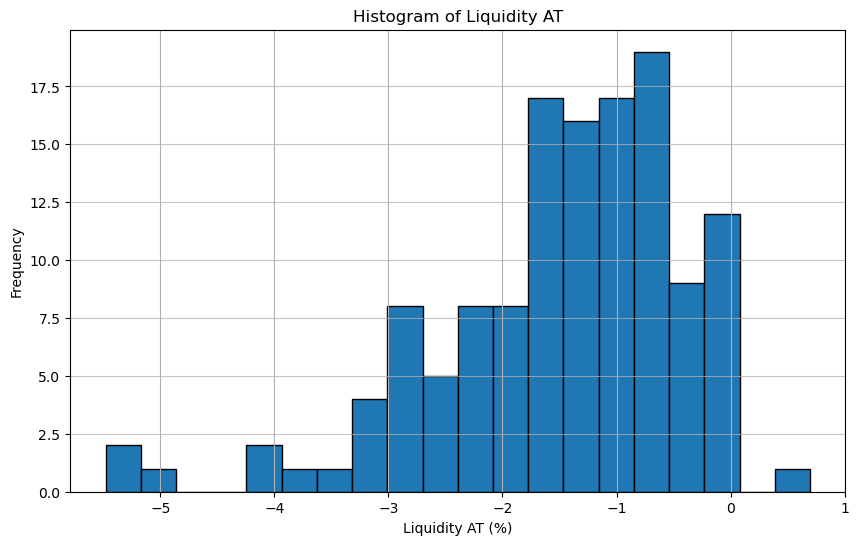

In [15]:
banks_calculated['Liquidity AT'].dropna().hist(bins=20, edgecolor='black', figsize=(10, 6))
plt.title('Histogram of Liquidity AT')
plt.xlabel('Liquidity AT (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

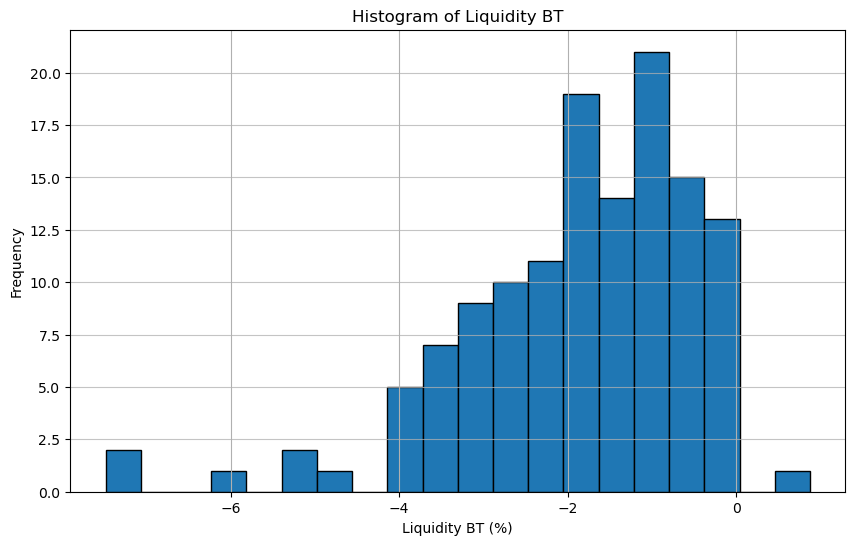

In [16]:
banks_calculated['Liquidity BT'].dropna().hist(bins=20, edgecolor='black', figsize=(10, 6))
plt.title('Histogram of Liquidity BT')
plt.xlabel('Liquidity BT (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Conclusion
This exercise highlights the importance of creativity when working with inconsistent financial data. Banks report unrealized gains and losses differently—some before tax, others after—which complicates direct comparisons. By creatively restructuring the API data and aligning mismatched fields, we were able to standardize the information and calculate meaningful ratios like unrealized losses as a percentage of total assets. This approach is crucial for uncovering hidden risks, such as those that contributed to the collapse of Silicon Valley Bank, and shows how flexible thinking leads to more accurate, insightful analysis.